In [1]:
!pip install -q tensorflow-probability

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [19]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(100, 100, 3))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [ ]:
get_decoder().summary()

## Standalone VQ-VAE model

In [ ]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(100, 100, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

In [22]:
from tensorflow.python.ops.gen_data_flow_ops import map_stage
class VQVAETrainer(keras.models.Model):

        
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")
        
    
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            x,y = data
            # print(y.dtype)
            # print(x.dtype)
            x = tf.cast(x,tf.float32)
            y = tf.cast(y,tf.float32)
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((y - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

## Load and preprocess the MNIST dataset

##Download Dataset ***`Don't Execute`***

In [23]:
import os

In [24]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d prondeau/the-car-connection-picture-dataset

In [ ]:
!unzip '/content/the-car-connection-picture-dataset.zip' -d '/content/data'

In [26]:
path = '/content/data/'

In [27]:
files = os.listdir(path)

In [28]:
files = files[:len(files) // 10] #Because The Google Colab's RAM Is not large 
                                #So We Take Only The First Half Of The Dataset

In [29]:
#Add Some Motion Blur Effect
kernel_size = 10
kernel_v = np.zeros((kernel_size, kernel_size))
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
kernel_v /= kernel_size

In [30]:
DATASET_SIZE = len(files)
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [31]:
import cv2

In [32]:
X = np.zeros((DATASET_SIZE,IMG_HEIGHT,IMG_WIDTH,3))
y = np.zeros((DATASET_SIZE,IMG_HEIGHT,IMG_WIDTH,3))
for index , filename in enumerate(files):
  img = cv2.imread(path + filename)
  img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH)) / 255
  X[index] = cv2.filter2D(img, -1, kernel_v)
  y[index] = img

In [33]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# print(x_train.shape)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
x_train_scaled = X - 0.5

data_variance = np.var(x_train_scaled / 255.0)

## Train the VQ-VAE model

In [34]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(tf.convert_to_tensor(X),tf.convert_to_tensor(y), epochs=2500, batch_size=128)

Streaming output truncated to the last 5000 lines.
51/51 [==============================] - 5s 93ms/step - loss: 1428178.5577 - reconstruction_loss: 13710.3760 - vqvae_loss: 1414618.1514
Epoch 840/2500
51/51 [==============================] - 5s 92ms/step - loss: 1425281.1755 - reconstruction_loss: 13696.6406 - vqvae_loss: 1411628.4038
Epoch 841/2500
51/51 [==============================] - 5s 92ms/step - loss: 1397780.9615 - reconstruction_loss: 13720.0254 - vqvae_loss: 1384037.5192
Epoch 842/2500
51/51 [==============================] - 5s 92ms/step - loss: 1399701.2716 - reconstruction_loss: 13709.1377 - vqvae_loss: 1386002.1562
Epoch 843/2500
51/51 [==============================] - 5s 93ms/step - loss: 1416629.8197 - reconstruction_loss: 13721.0430 - vqvae_loss: 1402881.2692
Epoch 844/2500
51/51 [==============================] - 5s 94ms/step - loss: 1404297.4880 - reconstruction_loss: 13677.7939 - vqvae_loss: 1390592.8077
Epoch 845/2500
51/51 [==============================] - 5s

## Reconstruction results on the test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


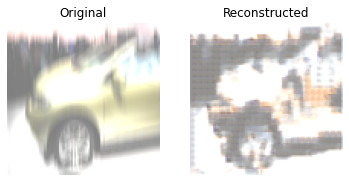

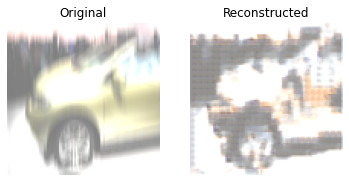

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


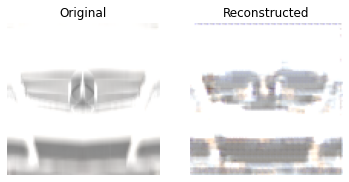

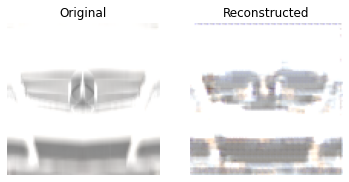

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


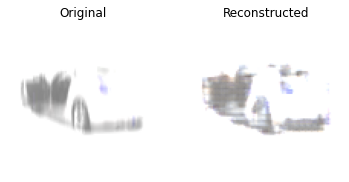

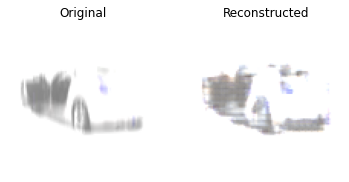

In [35]:

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(X), 3)
test_images = X[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)